In [1]:
import pandas as pd
import re
import nltk
import gensim

train_df = pd.read_csv("../techproject/train_data.txt",
                       engine="python",
                       sep=" ::: ",
                       names=['id', "movie", "genre", "summary"])

test_df = pd.read_csv("../techproject/test_data_solution.txt",
                      engine="python",
                      sep=" ::: ",
                      names=['id', "movie", "genre", "summary"])


In [2]:
# Save the DataFrame to a CSV file
train_df.to_csv('train_data_output.csv', index=False)
test_df.to_csv('test_data_output.csv', index=False)

# Load the two DataFrames from CSV files
df1 = pd.read_csv('test_data_output.csv')
df2 = pd.read_csv('train_data_output.csv')

# Concatenate the two DataFrames along the rows
merged_data = pd.concat([df1, df2], axis=0, ignore_index=True)

# Save the concatenated DataFrame to a CSV file
merged_data.to_csv('merged_data.csv', index=False)

In [3]:
df_merged = pd.read_csv('merged_data.csv')

In [4]:
# final data for processing Remove the columns
df = df_merged.drop(columns=['id', 'movie'], axis=1)
df = df.sample(frac=1)
df

,genre,summary
18994,documentary,"Just before Christmas 2004, two men dressed as..."
66670,documentary,This documentary features the State Department...
98184,documentary,Too Soon for Sorry explores the cultural and e...
100747,horror,Tom Riley thought he was getting the deal of a...
71929,drama,"After his mother's devastating death, Phoenix ..."
...,...,...
64438,sport,Hudson Leick has been teaching yoga for over t...
34483,sci-fi,A planet is discovered in the same orbit as Ea...
62005,drama,"""Callback"" is a film about two struggling acto..."
35993,documentary,"Filmed over three years on China's railways, T..."


In [5]:
# Data Engineering
# Case conversion, Removing special characters, 
# Removing accents, Normalize spaces

from nltk.stem import WordNetLemmatizer

# lemmatizer
lemmatizer = WordNetLemmatizer()

# Remove punctuation
df['summary'] = \
    df['summary'].map(lambda x: re.sub('[:,\.!?-]', '', x))

# Convert the titles to lowercase
df['summary'] = \
    df['summary'].map(lambda x: x.lower())

# Perform lemmatization
df['summary'] = \
    df['summary'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# remove accents
def remove_accents():
    df.summary = [unidecode.unidecode(text) for text in df.summary.values]
    
#normalized space  
def normalize_spaces():
    df.summary = [re.sub(r"\s+"," ",text) for text in df.summary.values]



In [6]:
# remove stopwords
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = df.summary.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
df['summary'] = remove_stopwords(data_words)

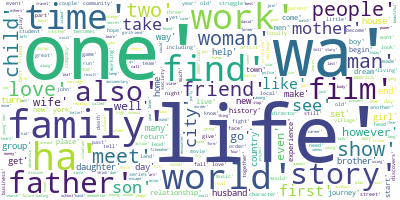

In [7]:
# Exploratory Analysis

# Import the wordcloud library
from wordcloud import WordCloud

long_string = ','.join(df['summary'].apply(str))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=6000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()


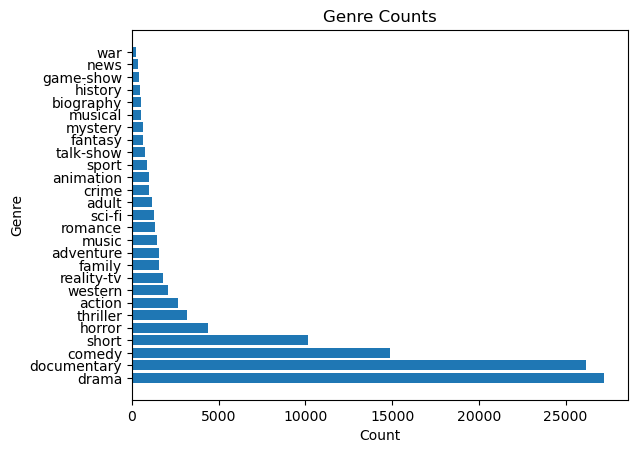

In [8]:
import matplotlib.pyplot as plt

counts = df['genre'].value_counts()

plt.barh(counts.index, counts.values)
plt.xlabel('Count')
plt.ylabel('Genre')
plt.title('Genre Counts')
plt.show()

In [9]:
## tokenizer

import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 2), (5, 1), (6, 3), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 3), (26, 1), (27, 1), (28, 1), (29, 1)]


In [10]:
#split the data for training and test

from sklearn.model_selection import train_test_split

X = df['summary']
y = df['genre']

# Split the data into training and testing sets, stratifying by y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

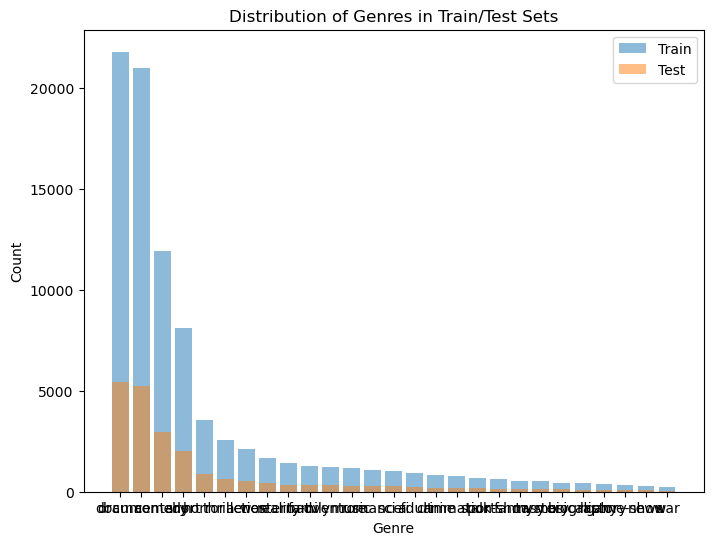

In [23]:
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(train_counts.index, train_counts.values, alpha=0.5, label='Train')
ax.bar(test_counts.index, test_counts.values, alpha=0.5, label='Test')
ax.set_xlabel('Genre')
ax.set_ylabel('Count')
ax.set_title('Distribution of Genres in Train/Test Sets')
ax.legend()
plt.show()
